<font size="+3"><strong>4.2. Predicting Damage with Logistic Regression</strong></font>

In [1]:
import sqlite3
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
VimeoVideo("665414074", h="d441543f18", width=600)

# Prepare Data

## Import 

In [3]:
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 4
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")

    
    return df

In [4]:
VimeoVideo("665414541", h="dfe22afdfb", width=600)

**Task 4.2.1:** Complete the `wrangle` function above so that the it returns the results of `query` as a DataFrame. Be sure that the index column is set to `"b_id"`. Also, the path to the SQLite database is `"/home/jovyan/nepal.sqlite"`.

- [<span id='technique'>Read SQL query into a DataFrame using <span id='tool'>pandas</span></span>.](../%40textbook/10-databases-sql.ipynb#Using-pandas-with-SQL-Databases)
- [<span id='technique'>Write a function in <span id='tool'>Python</span></span>.](../%40textbook/02-python-advanced.ipynb#Functions)

In [5]:
df = wrangle("/home/jovyan/nepal.sqlite")
df.head()

,building_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,superstructure,damage_grade
b_id,,,,,,,,,,,,,,,,,
164002,164002,3,3,20,560,18,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Repaired and used,"Stone, mud mortar",Grade 2
164081,164081,2,2,21,200,12,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",Grade 2
164089,164089,3,3,18,315,20,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",Grade 2
164098,164098,2,2,45,290,13,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",Grade 3
164103,164103,2,2,21,230,13,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",Grade 3


In [6]:
# Check your work
assert df.shape[0] == 70836, f"`df` should have 70,836 rows, not {df.shape[0]}."

There seem to be several features in `df` with information about the condition of a property after the earthquake.

In [7]:
VimeoVideo("665414560", h="ad4bba19ed", width=600)

**Task 4.2.2:** Add to your wrangle function so that these features are dropped from the DataFrame. Don't forget to rerun all the cells above. 

- [<span id='technique'>Drop a column from a DataFrame using <span id='tool'>pandas</span></span>.](../%40textbook/03-pandas-getting-started.ipynb#Dropping-Columns)
- [<span id='technique'>Subset a DataFrame's columns based on column names in <span id='tool'>pandas</span></span>.](../%40textbook/04-pandas-advanced.ipynb#Subset-a-DataFrame-by-Selecting-One-or-More-Columns)

In [8]:
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 4
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")
    drop_cols = [col for col in df.columns if "post_eq" in col]
    
    df = df.drop(columns = drop_cols)
    
    return df

In [9]:
df = wrangle("/home/jovyan/nepal.sqlite")

In [10]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70836 entries, 164002 to 234835
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   building_id             70836 non-null  int64 
 1   count_floors_pre_eq     70836 non-null  int64 
 2   age_building            70836 non-null  int64 
 3   plinth_area_sq_ft       70836 non-null  int64 
 4   height_ft_pre_eq        70836 non-null  int64 
 5   land_surface_condition  70836 non-null  object
 6   foundation_type         70836 non-null  object
 7   roof_type               70836 non-null  object
 8   ground_floor_type       70836 non-null  object
 9   other_floor_type        70836 non-null  object
 10  position                70836 non-null  object
 11  plan_configuration      70836 non-null  object
 12  superstructure          70836 non-null  object
 13  damage_grade            70836 non-null  object
dtypes: int64(5), object(9)
memory usage: 8.1+ MB
Non

In [11]:
# Check your work
assert (
    df.filter(regex="post_eq").shape[1] == 0
), "`df` still has leaky features. Try again!"

We want to build a **binary classification** model, but our current target `"damage_grade"` has more than two categories.

In [12]:
VimeoVideo("665414603", h="12b3d2f23e", width=600)

**Task 4.2.3:** Add to your wrangle function so that it creates a new target column `"severe_damage"`. For buildings where the `"damage_grade"` is Grade 4 or above, `"severe_damage"` should be `1`. For all other buildings, `"severe_damage"` should be `0`. Don't forget to drop `"damage_grade"` to avoid leakage, and rerun all the cells above.

- [<span id='technique'>Access a substring in a Series using <span id='tool'>pandas</span></span>.](../%40textbook/03-pandas-getting-started.ipynb#Access-a-substring-in-a-Series)
- [<span id='technique'>Drop a column from a DataFrame using <span id='tool'>pandas</span></span>.](../%40textbook/03-pandas-getting-started.ipynb#Dropping-Columns)
- [<span id='technique'>Recast a column as a different data type in <span id='tool'>pandas</span></span>.](../%40textbook/03-pandas-getting-started.ipynb#Recasting-Data)

In [13]:
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 4
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")
    drop_cols = [col for col in df.columns if "post_eq" in col]
    
    df = df.drop(columns = drop_cols)
    
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
    
    df = df.drop(columns = "damage_grade")
    
    
    return df

In [14]:
df = wrangle("/home/jovyan/nepal.sqlite")

In [15]:
print(df["severe_damage"].value_counts())

1    45519
0    25317
Name: severe_damage, dtype: int64


In [16]:
# Check your work
assert (
    "damage_grade" not in df.columns
), "Your DataFrame should not include the `'damage_grade'` column."
assert (
    "severe_damage" in df.columns
), "Your DataFrame is missing the `'severe_damage'` column."
assert (
    df["severe_damage"].value_counts().shape[0] == 2
), f"The `'damage_grade'` column should have only two unique values, not {df['severe_damage'].value_counts().shape[0]}"

## Explore

Since our model will be a type of linear model, we need to make sure there's no issue with multicollinearity in our dataset.

In [17]:
VimeoVideo("665414636", h="d34256b4e3", width=600)

**Task 4.2.4:** Plot a correlation heatmap of the remaining numerical features in `df`. Since `"severe_damage"` will be your target, you don't need to include it in your heatmap. 

- [What's a <span id='term'>correlation coefficient</span>?](../%40textbook/05-pandas-summary-statistics.ipynb#Correlations)
- [What's a <span id='term'>heatmap</span>?](../%40textbook/09-visualization-seaborn.ipynb#Correlation-Heatmaps)
- [<span id='technique'>Create a correlation matrix in <span id='tool'>pandas</span></span>.](../%40textbook/07-visualization-pandas.ipynb#Correlation-Matrices)
- [<span id='technique'>Create a heatmap in <span id='tool'>seaborn</span></span>.](../%40textbook/09-visualization-seaborn.ipynb#Correlation-Heatmaps)

Do you see any features that you need to drop?

<AxesSubplot:>

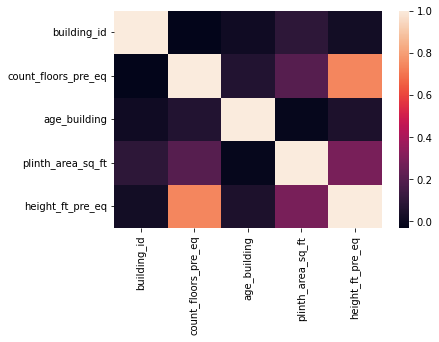

In [18]:
# Create correlation matrix
correlation = df.select_dtypes("number").drop(columns="severe_damage").corr()

# Plot heatmap of `correlation`
sns.heatmap(correlation)

**Task 4.2.5:** Change `wrangle` function so that it drops the `"count_floors_pre_eq"` column. Don't forget to rerun all the cells above. 

- [<span id='technique'>Drop a column from a DataFrame using <span id='tool'>pandas</span></span>.](../%40textbook/03-pandas-getting-started.ipynb#Dropping-Columns)

In [19]:
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 4
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")
    drop_cols = [col for col in df.columns if "post_eq" in col]
    
    df = df.drop(columns = drop_cols)
    
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
    
    df = df.drop(columns = "damage_grade")
    df = df.drop(columns = "count_floors_pre_eq")
    
    
    return df

In [20]:
df = wrangle("/home/jovyan/nepal.sqlite")

In [21]:
# Check your work
assert (
    "count_floors_pre_eq" not in df.columns
), "Did you drop the `'count_floors_pre_eq'` column?"

Before we build our model, let's see if we can identify any obvious differences between houses that were severely damaged in the earthquake (`"severe_damage"==1`) those that were not (`"severe_damage"==0`). Let's start with a numerical feature. 

In [22]:
VimeoVideo("665414667", h="f39c2c21bc", width=600)

**Task 4.2.6:** Use seaborn to create a boxplot that shows the distributions of the `"height_ft_pre_eq"` column for both groups in the `"severe_damage"` column. Remember to label your axes. 

- [What's a <span id='term'>boxplot</span>?](../%40textbook/06-visualization-matplotlib.ipynb#Boxplots)
- [<span id='technique'>Create a boxplot using <span id='tool'>Matplotlib</span></span>.](../%40textbook/06-visualization-matplotlib.ipynb#Boxplots)

Text(0.5, 1.0, 'Distribution of Building Height by Class')

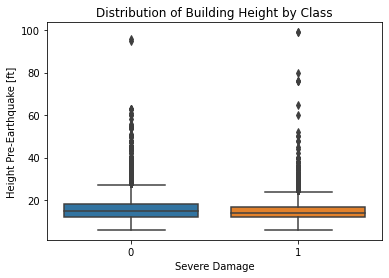

In [23]:
# Create boxplot
sns.boxplot(x="severe_damage", y="height_ft_pre_eq", data=df)

# Label axes
plt.xlabel("Severe Damage")
plt.ylabel("Height Pre-Earthquake [ft]")
plt.title("Distribution of Building Height by Class")

Before we move on to the many categorical features in this dataset, it's a good idea to see the balance between our two classes. What percentage were severely damaged, what percentage were not? 

In [24]:
VimeoVideo("665414684", h="81295d5bdb", width=600)

**Task 4.2.7:** Create a bar chart of the value counts for the `"severe_damage"` column. You want to calculate the relative frequencies of the classes, not the raw count, so be sure to set the `normalize` argument to `True`.

- [What's a <span id='term'>bar chart</span>?](../%40textbook/06-visualization-matplotlib.ipynb#Bar-Charts)
- [What's a <span id='technique'>majority class</span>?](../%40textbook/14-ml-classification.ipynb#Majority-and-Minority-Classes)
- [What's a <span id='technique'>minority class</span>?](../%40textbook/14-ml-classification.ipynb#Majority-and-Minority-Classes)
- [<span id='technique'>Aggregate data in a Series using `value_counts` in <span id='tool'>pandas</span></span>.](../%40textbook/04-pandas-advanced.ipynb#Working-with-value_counts-in-a-Series)
- [<span id='technique'>Create a bar chart using <span id='tool'>pandas</span></span>.](../%40textbook/07-visualization-pandas.ipynb#Bar-Charts)

<AxesSubplot:title={'center':'Class Balance'}, xlabel='Class', ylabel='Relative Frequency'>

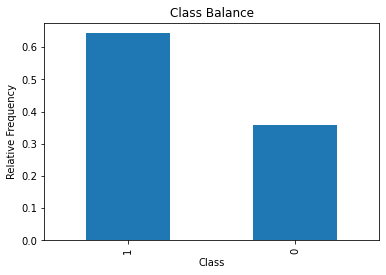

In [25]:
# Plot value counts of `"severe_damage"`
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Class", ylabel="Relative Frequency", title="Class Balance"
)

In [26]:
VimeoVideo("665414697", h="ee2d4f28c6", width=600)

**Task 4.2.8:** Create two variables, `majority_class_prop` and `minority_class_prop`, to store the normalized value counts for the two classes in `df["severe_damage"]`. 

- [<span id='technique'>Aggregate data in a Series using `value_counts` in <span id='tool'>pandas</span></span>.](../%40textbook/04-pandas-advanced.ipynb#Working-with-value_counts-in-a-Series)

In [27]:
majority_class_prop, minority_class_prop = df["severe_damage"].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)

0.6425969845841097 0.3574030154158902


In [28]:
# Check your work
assert (
    majority_class_prop < 1
), "`majority_class_prop` should be a floating point number between 0 and 1."
assert (
    minority_class_prop < 1
), "`minority_class_prop` should be a floating point number between 0 and 1."

In [29]:
VimeoVideo("665414718", h="6a1e0c1e53", width=600)

**Task 4.2.9:** Are buildings with certain foundation types more likely to suffer severe damage? Create a pivot table of `df` where the index is `"foundation_type"` and the values come from the `"severe_damage"` column, aggregated by the mean.

- [What's a <span id='term'>pivot table</span>?](../%40textbook/04-pandas-advanced.ipynb#Pivot-Tables)
- [<span id='technique'>Reshape a DataFrame based on column values in <span id='tool'>pandas</span></span>.](../%40textbook/04-pandas-advanced.ipynb#Reshape-a-DataFrame-based-on-column-values)

In [40]:
# Create pivot table
foundation_pivot = pd.pivot_table(
    df, index="foundation_type", values="severe_damage", aggfunc=np.mean
).sort_values(by="severe_damage")
foundation_pivot

,severe_damage
foundation_type,
RC,0.026224
Bamboo/Timber,0.324074
Cement-Stone/Brick,0.421908
Mud mortar-Stone/Brick,0.687792
Other,0.818898


In [31]:
VimeoVideo("665414734", h="46de83f96e", width=600)

**Task 4.2.10:** How do the proportions in `foundation_pivot` compare to the proportions for our majority and minority classes? Plot `foundation_pivot` as horizontal bar chart, adding vertical lines at the values for `majority_class_prop` and `minority_class_prop`.

- [What's a <span id='term'>bar chart</span>?](../%40textbook/07-visualization-pandas.ipynb#Bar-Charts)
- [<span id='technique'>Add a vertical or horizontal line across a plot using <span id='term'>Matplotlib</span></span>.](../%40textbook/06-visualization-matplotlib.ipynb#Add-a-vertical-or-horizontal-line-across-a-plot)
- [<span id='technique'>Create a bar chart using <span id='tool'>pandas</span></span>.](../%40textbook/07-visualization-pandas.ipynb#Bar-Charts)

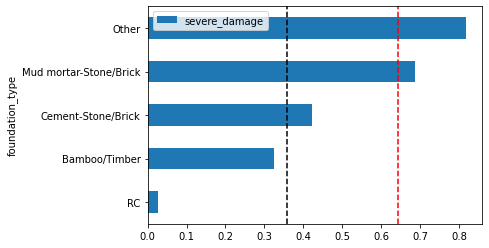

In [44]:
# Plot bar chart of `foundation_pivot`
foundation_pivot.plot(kind="barh")
plt.axvline(
    majority_class_prop, linestyle="--", color="red"
)
plt.axvline(
    minority_class_prop, linestyle="--", color="black"
)

In [33]:
VimeoVideo("665414748", h="8549a0f89c", width=600)

**Task 4.2.11:** Combine the [`select_dtypes`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html) and [`nunique`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nunique.html) methods to see if there are any high- or low-cardinality categorical features in the dataset. 

- [What are <span id='term'>high- and low-cardinality features</span>?](../%40textbook/14-ml-classification.ipynb#High-cardinality-Features)
- [<span id='technique'>Determine the unique values in a column using <span id='tool'>pandas</span></span>.](../%40textbook/03-pandas-getting-started.ipynb#Determine-the-unique-values-in-a-column) 
- [<span id='technique'>Subset a DataFrame's columns based on the column data types in <span id='tool'>pandas</span></span>.](../%40textbook/04-pandas-advanced.ipynb#Subset-the-Columns-of-a-DataFrame-Based-on-Data-Types)

In [45]:
# Check for high- and low-cardinality categorical features
# high-cardinality = "building_id"
df.select_dtypes("object").nunique()

land_surface_condition     3
foundation_type            5
roof_type                  3
ground_floor_type          5
other_floor_type           4
position                   4
plan_configuration        10
superstructure            11
dtype: int64

In [46]:
#dropping the high cardinality feature building_id
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 4
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")
    drop_cols = [col for col in df.columns if "post_eq" in col]
    
    df = df.drop(columns = drop_cols)
    
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
    
    df = df.drop(columns = "damage_grade")
    df = df.drop(columns = "count_floors_pre_eq")
    df = df.drop(columns = "building_id")
    
    return df

In [47]:
df = wrangle("/home/jovyan/nepal.sqlite")

## Split

**Task 4.2.12:** Create your feature matrix `X` and target vector `y`. Your target is `"severe_damage"`. 

- [What's a <span id='term'>feature matrix</span>?](../%40textbook/15-ml-regression.ipynb#Linear-Regression)
- [What's a <span id='term'>target vector</span>?](../%40textbook/15-ml-regression.ipynb#Linear-Regression)
- [<span id='technique'>Subset a DataFrame by selecting one or more columns in <span id='tool'>pandas</span></span>.](../%40textbook/04-pandas-advanced.ipynb#Subset-a-DataFrame-by-Selecting-One-or-More-Columns) 
- [<span id='technique'>Select a Series from a DataFrame in <span id='tool'>pandas</span></span>.](../%40textbook/04-pandas-advanced.ipynb#Combine-multiple-categories-in-a-Series) 

In [48]:
target = "severe_damage"
X = df.drop(columns=target)
y = df[target]

In [36]:
VimeoVideo("665414769", h="1bfddf07b2", width=600)

**Task 4.2.13:** Divide your data (`X` and `y`) into training and test sets using a randomized train-test split. Your test set should be 20% of your total data. And don't forget to set a `random_state` for reproducibility. 

- [<span id='technique'>Perform a randomized train-test split using <span id='tool'>scikit-learn</span></span>.](../%40textbook/14-ml-classification.ipynb#Randomized-Train-Test-split)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, 
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (56668, 11)
y_train shape: (56668,)
X_test shape: (14168, 11)
y_test shape: (14168,)


# Build Model

## Baseline

In [50]:
VimeoVideo("665414807", h="c997c58720", width=600)

**Task 4.2.14:** Calculate the baseline accuracy score for your model.

- [What's <span id='tool'>accuracy score</span>?](../%40textbook/14-ml-classification.ipynb#Calculating-Accuracy-Score)
- [<span id='technique'>Aggregate data in a Series using `value_counts` in <span id='tool'>pandas</span></span>.](../%40textbook/04-pandas-advanced.ipynb#Working-with-value_counts-in-a-Series)

In [51]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.64


## Iterate

In [52]:
VimeoVideo("665414835", h="1d8673223e", width=600)

**Task 4.2.15:** Create a pipeline named `model` that contains a `OneHotEncoder` transformer and a `LogisticRegression` predictor. Be sure you set the `use_cat_names` argument for your transformer to `True`. Then fit it to the training data. 

- [What's <span id='term'>logistic regression</span>?](../%40textbook/14-ml-classification.ipynb#Logistic-Regression)
- [What's <span id='term'>one-hot encoding</span>?](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#One-Hot-Encoding)
- [<span id='technique'>Create a pipeline in <span id='tool'>scikit-learn</span></span>.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Creating-a-Pipeline-in-scikit-learn)
- [<span id='technique'>Fit a model to training data in <span id='tool'>scikit-learn</span></span>.](../%40textbook/15-ml-regression.ipynb#Fitting-a-Model-to-Training-Data)

<div class="alert alert-block alert-info">
<b>Tip:</b> If you get a <code>ConvergenceWarning</code></b> when you fit your model to the training data, don't worry. This can sometimes happen with logistic regression models. Try setting the <code>max_iter</code> argument in your predictor to <code>1000</code>.
</div>

In [54]:
# Build model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000)
    
)
# Fit model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [55]:
# Check your work
assert isinstance(
    model, Pipeline
), f"`model` should be a Pipeline, not type {type(model)}."
assert isinstance(
    model[0], OneHotEncoder
), f"The first step in your Pipeline should be a OneHotEncoder, not type {type(model[0])}."
assert isinstance(
    model[-1], LogisticRegression
), f"The last step in your Pipeline should be LogisticRegression, not type {type(model[-1])}."
check_is_fitted(model)

## Evaluate

In [56]:
VimeoVideo("665414885", h="f35ff0e23e", width=600)

**Task 4.2.16:** Calculate the training and test accuracy scores for your models. 

- [<span id='technique'>Calculate the accuracy score for a model in <span id='term'>scikit-learn</span></span>.](../%40textbook/14-ml-classification.ipynb#Calculating-Accuracy-Score)
- [<span id='technique'>Generate predictions using a trained model in <span id='term'>scikit-learn</span></span>.](../%40textbook/15-ml-regression.ipynb#Generating-Predictions-Using-a-Trained-Model)

In [57]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.71
Test Accuracy: 0.72


# Communicate

In [58]:
VimeoVideo("665414902", h="f9bdbe9e75", width=600)

**Task 4.2.17:** Instead of using the `predict` method with your model, try `predict_proba` with your training data. How does the `predict_proba` output differ than that of `predict`? What does it represent?

- [<span id='technique'>Generate probability estimates using a trained model in <span id='tool'>scikit-learn</span></span>.](../%40textbook/14-ml-classification.ipynb#Probability-Estimates)

In [59]:
y_train_pred_proba = model.predict_proba(X_train)  # 0 not severely damaged, 1 severly damaged
print(y_train_pred_proba[:5]) ## left column not severely damaged prob, right column severely damaged prob

[[0.37111336 0.62888664]
 [0.32446811 0.67553189]
 [0.29789638 0.70210362]
 [0.3009527  0.6990473 ]
 [0.3174464  0.6825536 ]]


**Task 4.2.18:** Extract the feature names and importances from your `model`.

- [<span id='technique'>Access an object in a pipeline in <span id='tool'>scikit-learn</span></span>.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Accessing-an-Object-in-a-Pipeline)

In [61]:
features = model.named_steps["onehotencoder"].get_feature_names()
importances = model.named_steps["logisticregression"].coef_[0]

In [60]:
VimeoVideo("665414916", h="c0540604cd", width=600)

**Task 4.2.19:** Create a pandas Series named `odds_ratios`, where the index is `features` and the values are your the exponential of the `importances`. How does `odds_ratios` for this model look different from the other linear models we made in projects 2 and 3?

- [<span id='technique'>Create a Series in <span id='tool'>pandas</span></span>.](../%40textbook/04-pandas-advanced.ipynb#Subset-a-DataFrame-by-Selecting-One-or-More-Columns)

In [62]:
odds_ratios = pd.Series(np.exp(importances), index=features).sort_values()
odds_ratios.head()

superstructure_Brick, cement mortar    0.272501
foundation_type_RC                     0.322407
roof_type_RCC/RB/RBC                   0.372594
ground_floor_type_RC                   0.486571
plan_configuration_Multi-projected     0.560832
dtype: float64

In [64]:
VimeoVideo("665414943", h="56eb74d93e", width=600)

**Task 4.2.20:** Create a horizontal bar chart with the five largest coefficients from `odds_ratios`. Be sure to label your x-axis `"Odds Ratio"`.

- [What's a <span id='term'>bar chart</span>?](../%40textbook/06-visualization-matplotlib.ipynb#Bar-Charts)
- [<span id='technique'>Create a bar chart using <span id='tool'>Matplotlib</span></span>.](../%40textbook/06-visualization-matplotlib.ipynb#Bar-Charts)

<AxesSubplot:>

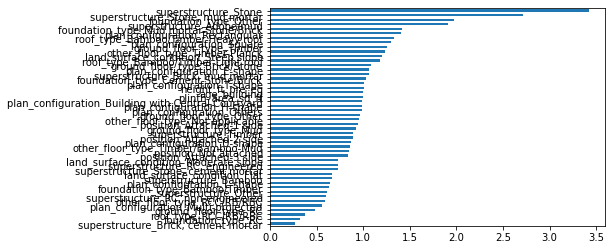

In [65]:
# Horizontal bar chart, five largest coefficients
odds_ratios.plot(kind="barh")

In [ ]:
VimeoVideo("665414964", h="a61b881450", width=600)

**Task 4.2.21:** Create a horizontal bar chart with the five smallest coefficients from `odds_ratios`. Be sure to label your x-axis `"Odds Ratio"`.

- [What's a <span id='term'>bar chart</span>?](../%40textbook/06-visualization-matplotlib.ipynb#Bar-Charts)
- [<span id='technique'>Create a bar chart using <span id='tool'>Matplotlib</span></span>.](../%40textbook/06-visualization-matplotlib.ipynb#Bar-Charts)

In [ ]:
# Horizontal bar chart, five smallest coefficients


---
Copyright © 2022 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
